source : https://www.analyticsvidhya.com/blog/2021/08/a-walk-through-of-regression-analysis-using-artificial-neural-networks-in-tensorflow/

In [1]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-01-05 19:29:54.223829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 19:29:54.307049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-01-05 19:29:54.307065: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
df_train = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final.zip")

In [3]:
df_test = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final.zip")

In [19]:
x_train, y_train = df_train.drop("ground_truth", axis=1), df_train["ground_truth"]
x_train.drop(["day","Id"], axis=1, inplace=True)
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns=x_train.columns)

y_train = y_train.apply(lambda x : x+1)

del df_train

In [5]:
x_test, y_test = df_test.drop("ground_truth", axis=1), df_test["ground_truth"]
x_test.drop(["day","Id"], axis=1, inplace=True)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns=x_test.columns)

y_test = y_test.apply(lambda x : x+1)

del df_test

In [8]:
# Creating model using the Sequential in tensorflow
def build_model_using_sequential(*hidden_units, input_dim=106, msle = MeanSquaredLogarithmicError()):
    model = Sequential()
    model.add(Dense(hidden_units[0], input_dim=input_dim, activation="relu",))
    for hu in hidden_units[1:]:
        model.add(Dropout(0.2))
        model.add(Dense(hu, activation="relu"))
    model.add(Dense(1, activation='linear'))

    model.compile(
        loss=msle,
        optimizer=Adam(learning_rate=0.01),
        metrics=[msle]
    )

    print(model.summary())
    return model

In [9]:
# build the model
model = build_model_using_sequential(16,16,16,input_dim=x_train.shape[1])

2022-01-05 19:31:58.865483: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1712      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,273
Trainable params: 2,273
Non-trainabl

In [10]:
with tf.device("gpu"):
    # train the model
    history = model.fit(
        x=x_train.values,
        y=y_train.values,
        epochs=25,
        batch_size=64,
        validation_data=(x_test,y_test)
    )

2022-01-05 19:31:59.971007: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1207128000 exceeds 10% of free system memory.


Epoch 1/25
44448/44485 [============================>.] - ETA: 0s - loss: 0.0153 - mean_squared_logarithmic_error: 0.0153

2022-01-05 19:32:51.553621: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2206077088 exceeds 10% of free system memory.


44485/44485 [==============================] - 78s 2ms/step - loss: 0.0152 - mean_squared_logarithmic_error: 0.0152 - val_loss: 0.0151 - val_mean_squared_logarithmic_error: 0.0151
Epoch 2/25
44485/44485 [==============================] - 72s 2ms/step - loss: 0.0154 - mean_squared_logarithmic_error: 0.0154 - val_loss: 0.0151 - val_mean_squared_logarithmic_error: 0.0151
Epoch 3/25
44485/44485 [==============================] - 72s 2ms/step - loss: 0.0154 - mean_squared_logarithmic_error: 0.0154 - val_loss: 0.0151 - val_mean_squared_logarithmic_error: 0.0151
Epoch 4/25
44485/44485 [==============================] - 73s 2ms/step - loss: 0.0154 - mean_squared_logarithmic_error: 0.0154 - val_loss: 0.0151 - val_mean_squared_logarithmic_error: 0.0151
Epoch 5/25
44485/44485 [==============================] - 63s 1ms/step - loss: 0.0154 - mean_squared_logarithmic_error: 0.0154 - val_loss: 0.0151 - val_mean_squared_logarithmic_error: 0.0151
Epoch 6/25
44485/44485 [==============================] 

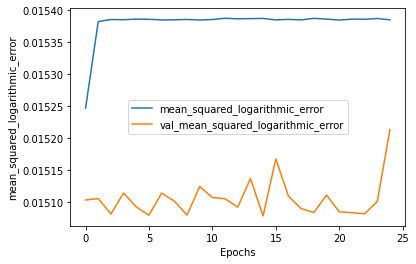

In [11]:
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [12]:
del df_test
del df_train

In [13]:
test_set = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_test_final.zip")

In [16]:
submission = test_set[["Id"]]

In [24]:
test_set.drop("Unnamed: 0", axis=1, inplace=True)

In [21]:
test_set.drop(["day","Id"], axis=1, inplace=True)
test_set.head()

,current hour precipitations (kg/m^2),next hour precipitation (kg/m^2),station_id,altitude (m),latitude,longitude,latitude_idx,longitude_idx,month,month_cos,...,3D_Arpege_isobar_600hpa_VerticalVelocity (Pa/s),3D_Arpege_isobar_600hpa_Geopotential (m^2/s^2),3D_Arpege_isobar_500hpa_Temperature (K),3D_Arpege_isobar_500hpa_RelavtiveHumidity (%),3D_Arpege_isobar_500hpa_WindSpeed (m/s),3D_Arpege_isobar_500hpa_WindDirection (deg),3D_Arpege_isobar_500hpa_WindComponentU (m/s),3D_Arpege_isobar_500hpa_WindComponentV (m/s),3D_Arpege_isobar_500hpa_VerticalVelocity (Pa/s),3D_Arpege_isobar_500hpa_Geopotential (m^2/s^2)
0,0.0,0.0,86118001,120,46,0,217,273,7,-1.0,...,0.050313,41769.363,253.42760,15.935472,5.843763,44.823340,-4.119983,-4.144466,0.024156,55295.285
1,0.0,0.0,86118001,120,46,0,217,273,7,-1.0,...,0.116777,41779.273,253.43576,20.216759,5.703158,45.653458,-4.073028,-3.991674,0.089902,55311.367
2,0.0,0.0,86118001,120,46,0,217,273,7,-1.0,...,0.034255,41759.110,253.48488,24.769560,5.187140,45.329548,-3.689022,-3.643088,0.114549,55296.350
3,0.0,0.1,86118001,120,46,0,217,273,7,-1.0,...,0.044748,41738.992,253.57262,29.092268,4.764898,43.618930,-3.288254,-3.456242,0.089390,55280.207
4,0.1,0.0,86118001,120,46,0,217,273,7,-1.0,...,0.112990,41751.055,253.62709,33.288578,4.690506,38.356937,-2.913704,-3.681483,0.068782,55297.290


In [25]:
y_pred = model.predict(test_set)

2022-01-05 20:42:58.169356: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2401027200 exceeds 10% of free system memory.


In [28]:
y_pred

array([[1.037151],
       [1.037151],
       [1.037151],
       ...,
       [1.037151],
       [1.037151],
       [1.037151]], dtype=float32)

In [31]:
submission = pd.concat([submission, pd.DataFrame({"Prediction" : list(y_pred)})])

In [32]:
submission

,Id,Prediction
0,86118001_1,1.037151
1,86118001_1,1.037151
2,86118001_1,1.037151
3,86118001_1,1.037151
4,86118001_1,1.037151
...,...,...
2831395,NaN,[1.037151]
2831396,NaN,[1.037151]
2831397,NaN,[1.037151]
2831398,NaN,[1.037151]


In [33]:
submission.to_csv("../submissions/submission_ann.csv", index=False)